# Portfolio Optimization Project

### CS/ECE/ISyE 524 — Introduction to Optimization — Fall 2024

### Project Members: Pawin Linmaneechote, Vincent Philavong, Jiajie Yao

## Table of Contents
1. Introduction  
    1.1. Project Motivation  
    1.2. Data Processing  
2. Mathematical Model  
    2.1 Minimum Volitaty Optimization (MVO) Model with L2 Regularlization (QP)  
    2.2 Markowitz Portfolio with Diversification (QP)  
    2.3 Sharpe Ratio with L2 Regularlization (NLP)  
3. Solution  
    3.1 Trade Off Analysis  
    3.2 Sensitivity Analysis  
4. Results and Discussion
5. Conclusion
6. Appendix
7. References

# 1. Introduction
## 1.1. Project Motivation
Investing is about making smart decisions to balance the trade-offs between risk and reward. In this project, we explore portfolio optimization by analyzing financial data from Yahoo Finance. We’ve chosen five asset sectors - Technology, Financials, Healthcare, Communication Services, and Industrials - to build a diversified portfolio. This selection spreads risk across industries while aiming to capture each sector’s growth potential. The list of the stock sectors and the individual stocks can be seen below.
- Technology
    - Apple (AAPL)
    - Uber (UBER)
    - Microsoft (MSFT)
    - NVIDIA (NVDA)
    - Advanced Micro Devices (AMD)
- Financial
    - Discover (DFS)
    - JP Morgan (๋JPM)
    - Synchrony (SYF)
    - American Express (AXP)
    - Goldman Sachs (GS)
- Health Care
    - Pfizer (PFE)
    - Johnson & Johnson (JNJ)
    - Merck Sharp & Dohme (MRK)
    - United Health Group (UNH)
    - ABBVie (ABBV)
- Communication Services
    - Meta (META)
    - Google (GOOG)
    - Netflix (NFLX)
    - T-Mobile (TMUS)
    - The Walt Disney Services (DIS)
- Industrials
    - Caterpillar (CAT)
    - RTX Coorporation (RTX)
    - The Boeing Company (BA)
    - Union Pacific Corperation (UNP)
    - Eaton Corporation PLC (ETN)

Our project focuses on optimizing three models. The first model, also known as the Minimum Volitaty Optimization (MVO), addressing the challenge of balancing variance in addition to diversification by analyzing the performance and relationships between the selected stocks. The second, known as the, Markowitz Model, builds on the baseline by of the variance model by tranforming the model into a trade-off between returns, variance, and diversification, which we believe will give a better result for the allocations. For the third model, we introduce a Sharpe Ratio model, focusing on maximizing the Sharpe Ratio with diversification to evaluate the effeciency of the stock allocations.

Portfolio optimization has been a topic of interest for investors and researchers for decades. It’s rooted in the uncertainty of financial markets, where both short-term gains and long-term stability needed careful evaluation. The economist, Harry Markowitz, revolutionized this field in 1952 with his paper Portfolio Selection, introducing diversification as a way to reduce risk (Team Investopedia, 2023). His work laid the groundwork for modern portfolio theory (MPT) and earned him a Nobel Prize. Yet, as markets continue to evolve, ongoing research is critical to adapting strategies for changing conditions like volatility, economic shifts, and new investor behaviors.

This report is structured into four sections: the Mathematical Model, where we define the decision variables, constraints, and objective function; the Solution, where we implement the model in Julia; Results and Discussion, where we present and interpret the outcomes; and the Conclusion, summarizing our findings and proposing future directions.

In [22]:
using CSV, DataFrames, Dates, Statistics, JuMP, Ipopt, PyPlot, LinearAlgebra

directory_path = "data_files/"

result_df = DataFrame(StockName = String[], OpenStock = Float64[], 
                      CloseStock = Float64[], EquityPercent = Float64[])

stock_sector = CSV.read("Stock Sheet.csv", DataFrame)
rename!(stock_sector, Symbol("Ticker") => :StockName) 

for file in readdir(directory_path)
    if endswith(file, ".csv")
        file_path = joinpath(directory_path, file)
        stock_df = CSV.read(file_path, DataFrame)
        
        stock_df.Date = Date.(string.(stock_df.Date), "yyyy-mm-dd")
        sort!(stock_df, :Date)  
        
        stock_name = splitext(basename(file))[1]
        
        open_price = stock_df.Open[1]
        close_price = stock_df.Close[end]

        equity_percent = ((close_price - open_price) / open_price) * 100

        push!(result_df, (stock_name, open_price, close_price, equity_percent))
    end
end

final_df = leftjoin(result_df, stock_sector[:, [:StockName, :StockSector]], on = :StockName)

select!(final_df, [:StockName, :OpenStock, :CloseStock, :EquityPercent, :StockSector])

println(final_df)


25×5 DataFrame
 Row │ StockName  OpenStock  CloseStock  EquityPercent  StockSector            
     │ String     Float64    Float64     Float64        String31?              
─────┼─────────────────────────────────────────────────────────────────────────
   1 │ AAPL         64.1925      223.45       248.094   Technology
   2 │ UBER         26.06         74.15       184.536   Technology
   3 │ NVDA          5.216       139.91      2582.32    Technology
   4 │ MSFT        144.37        411.46       185.004   Technology
   5 │ AMD          36.06        141.66       292.845   Technology
   6 │ DFS          83.24        151.85        82.4243  Financial
   7 │ JPM         128.69        221.49        72.1113  Financial
   8 │ SYF          36.34         56.82        56.3566  Financial
   9 │ AXP         118.89        275.94       132.097   Financial
  10 │ GS          218.01        526.96       141.714   Financial
  11 │ PFE          35.6831       27.99       -21.5595  Health Care
  12 │ JNJ  

## 1.2 Data Preparation

In [19]:
#= 
    Define current directory and read the CSV files
=#
directory_path = "data_files/"

# Initialize an empty DataFrame to hold daily returns of each asset
returns_df = DataFrame(Date = Date[])

# Read CSV file
for file in readdir(directory_path)
    if endswith(file, ".csv")
        file_path = joinpath(directory_path, file)
        stock_df = CSV.read(file_path, DataFrame)
        stock_df.Date = Date.(string.(stock_df.Date), "yyyy-mm-dd")
        sort!(stock_df, :Date)
        stock_name = splitext(basename(file))[1]
        stock_df[!, :DailyReturn] = [missing; diff(log.(stock_df.Close))]
        stock_returns = stock_df[:, [:Date, :DailyReturn]]
        rename!(stock_returns, :DailyReturn => stock_name)
        if nrow(returns_df) == 0
            returns_df = stock_returns
        else
            returns_df = outerjoin(returns_df, stock_returns, on = :Date)
        end
    end
end

# Remove rows with missing values
complete_cases = dropmissing(returns_df, disallowmissing=true)
CSV.write("complete_cases.csv", complete_cases)

#= 
    Extract Asset Names and Prepare Data
=#

col_names = names(complete_cases)
println("Column names:", col_names)
println("Type of column names:", typeof.(col_names))

if eltype(col_names) == String
    asset_names = setdiff(col_names, ["Date"])
elseif eltype(col_names) == Symbol
    asset_names = setdiff(col_names, [:Date])
else
    error("Unexpected column name types.")
end

asset_names = string.(asset_names)

# Extract the matrix of returns
returns_matrix = Matrix(complete_cases[:, asset_names])

#= 
    Compute Expected Returns and Covariance Matrix ---
=#

trading_days = 252  

# Compute expected daily returns
μ_daily = mean(returns_matrix, dims=1)
μ_daily = vec(μ_daily) 

# Annualize expected returns
μ = (1 .+ μ_daily) .^ trading_days .- 1
println("Length of μ:", length(μ))

# Compute daily covariance matrix
Σ_daily = cov(returns_matrix, dims=1)

# Annualize covariance matrix
Σ = Σ_daily * trading_days

# Size of Σ
println("Size of Σ:", size(Σ))

# Number of assets
n_assets = length(μ)
println("Number of assets (n_assets):", n_assets)

Column names:["Date", "AAPL", "ABBV", "AMD", "AXP", "BA", "CAT", "DFS", "DIS", "ETN", "GOOG", "GS", "JNJ", "JPM", "META", "MRK", "MSFT", "NFLX", "NVDA", "PFE", "RTX", "SYF", "TMUS", "UBER", "UNH", "UNP"]
Type of column names:DataType[String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String]
Length of μ:25
Size of Σ:(25, 25)
Number of assets (n_assets):25


In [20]:
# Load stock sheet and create sector mappings
stock_sheet = CSV.read("Stock Sheet.csv", DataFrame)

# Define the list of tickers in your portfolio
tickers = ["AAPL", "ABBV", "AMD", "AXP", "BA", "CAT", "DFS", "DIS", "ETN", 
           "GOOG", "GS", "JNJ", "JPM", "META", "MRK", "MSFT", "NFLX", "NVDA", 
           "PFE", "RTX", "SYF", "TMUS", "UBER", "UNH", "UNP"]

# Create a mapping from tickers to their sectors
ticker_to_sector = Dict(stock_sheet.Ticker .=> stock_sheet.StockSector)

# Check for missing sectors
missing_tickers = [ticker for ticker in tickers if !haskey(ticker_to_sector, ticker)]
if !isempty(missing_tickers)
    println("The following tickers are missing in the stock sheet: ", missing_tickers)
end

# Group indices by sector
sector_id = Dict()
for (i, ticker) in enumerate(tickers)
    if haskey(ticker_to_sector, ticker)
        sector = ticker_to_sector[ticker]
        if !haskey(sector_id, sector)
            sector_id[sector] = Int[]
        end
        push!(sector_id[sector], i)
    end
end

# 2. Mathematical Model

## 2.1 Assumptions

Our assumptions for this portfolio optimization is based on several key principles
1. Diversification: We assume that selecting stocks from diverse sections will reduce the overall portfolio risk while maximize the return opportunities from each sector
2. Model Framework:
   - The baseline model is built on the mean variance model, which assumes that the historical returns and covariances would be sufficient to estimate risk and return
   - The Ridge Regression model assumes that penalizing extreme portfolio weights would increase the diversification of our portfolio
   - The Sharpe SOCP model assumes that the Sharpe ratio would balance the risk and return for an investor-focused outcome
3. Market Dynamics: We assume that market volatility is stab;e or fluctuate within a certain range during our analysis
4. Investor Behavior: The models we use will assume a rational investor with the objective to maximize returns while minimizing risk.

## 2.2 Models 

We established allocation percentage constraints for our models to ensure balanced investments. For individual stocks, we set a lower bound of 0.02 and an upper bound of 0.1 for their allocations. Additionally, for each sector, we implemented a lower bound of 0.1 and an upper bound of 0.4 on the total allocation.

### 2.2.1 Minimum Volitaty Optimization Model with Diversification Term (QP)

In our initial model, we aim to optimize the portfolio by balancing the trade-off between maximizing returns and minimizing risk. This is achieved using a diversification penalty factor ($\gamma$), which controls the level of emphasis placed on risk relative to returns. The optimization problem is mathematically defined as follows:

#### Parameters:
- $\Sigma$: Covariance matrix of asset returns.
- $\mu$: Vector of expected returns for each asset.
- $\gamma$: Diversification penalty factor.
- $n_{assets}$: Number of assets in the portfolio
- $ \text{sector} $: Mapping of sectors to asset indices.


#### Decision Variables:

- $x_{\text{i}}:$ Percentage of the total budget allocated to asset $ i, \quad i \in \{1, 2,\ldots, n_{\text{assets}}\}. $

#### Constraints:  
1. Bounds on Allocation  
\begin{aligned}
0.02 \leq x_i \leq 0.10, \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}.
\end{aligned}
2. Budget Constraint
\begin{aligned}  
\sum_{i=1}^{n_{\text{assets}}} x_i = 1.
\end{aligned}
3. Sector Allocation Constraints
\begin{aligned}
0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40, \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}

#### Objective Functions:
\begin{aligned}
\text{Minimize} \quad x^\top \Sigma x + \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2
\end{aligned}  
Where:
- $ x^\top \Sigma x $ : Portfolio variance (risk).  
- $ \sum_{i=1}^{n_{\text{assets}}} x_i^2 $ : Penalty term to promote diversification.


#### Final Model:
\begin{aligned}
\text{Minimize} \quad & x^\top \Sigma x + \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 \\
\text{Subject to} \quad & \sum_{i=1}^{n_{\text{assets}}} x_i = 1, \\
& 0.02 \leq x_i \leq 0.1 \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}, \\
& 0.10 \leq \sum_{i \in \text{sector} j} x_i \leq 0.40 \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}


### 2.2.2 Markowitz Portfolio with Diversification (QP)

While experimenting with initial model, we found out that NVDA overpowers all the other stocks in returns. So we decided to add a trade-off for risk and diversification by adding a Ridge regularization term. This is beneficial as Ridge regularization is a smoothing algorithm which results in values being closer in magnitude. While the initial model focused solely on maximizing returns and minimizing risk, this updated formulation includes a diversification penalty factor ($\gamma$) that penalizes the concentration of portfolio weights. We also have a risk aversion parameter ($\lambda$) to control the trade-off between the return and the risk. The optimization problem is defined as follows:


#### Parameters:
- $\Sigma$: Covariance matrix of asset returns.
- $\mu$: Vector of expected returns for each asset.
- $\gamma$: Diversification penalty factor.
- $n_{assets}$: Number of assets in the portfolio
- $ \text{sector} $: Mapping of sectors to asset indices.
- $\lambda $: Risk aversion parameter that controls the trade-off between return and risk.


#### Decision Variables:

- $x_{\text{i}}:$ Percentage of the total budget allocated to asset $ i, \quad i \in \{1, 2,\ldots, n_{\text{assets}}\} $

#### Constraints:  
1. Bounds on Allocation  
\begin{aligned}
0.02 \leq x_i \leq 0.10, \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}
\end{aligned}
2. Budget Constraint
\begin{aligned}  
\sum_{i=1}^{n_{\text{assets}}} x_i = 1
\end{aligned}
3. Sector Allocation Constraints
\begin{aligned}
0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40, \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}
\end{aligned}

#### Objective Function
\begin{aligned}
\text{Maximize} \quad \mu^\top x - \lambda (x^\top \Sigma x) - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2
\end{aligned}
Where:
- $ \mu^\top x $ : Expected return of the portfolio.
- $ x^\top \Sigma x $ : Portfolio variance (risk).
- $ \sum_{i=1}^{n_{\text{assets}}} x_i^2 $ : Penalty term to promote diversification.

#### Final Model
\begin{aligned}
\text{Maximize} \quad & \mu^\top x - \lambda (x^\top \Sigma x) - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 \\
\text{Subject to} \quad & \sum_{i=1}^{n_{\text{assets}}} x_i = 1, \\
& 0.02 \leq x_i \leq 0.1 \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}, \\
& 0.10 \leq \sum_{i \in \text{sector} j} x_i \leq 0.40 \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}


### 2.2.3 Sharpe Ratio with Diversification (QP)

In this model, we aim to optimize the Sharpe ratio, a measure of risk-adjusted return where we believe that it would increase the overall efficiency. The Sharpe model includes a risk-free rate ($r_f$) and a divserification penalty factor ($\gamma$). The mathematical formulation is as follows:

#### Parameters:
- $\Sigma$: Covariance matrix of asset returns.
- $\mu$: Vector of expected returns for each asset.
- $\gamma$: Diversification penalty factor.
- $n_{assets}$: Number of assets in the portfolio
- $r_f$ Risk-free rate (set to 0 in this model)
- $ \text{sector} $: Mapping of sectors to asset indices.

#### Decision Variables:

- $x_{\text{i}}:$ Percentage of the total budget allocated to asset $ i, \quad i \in \{1, 2,\ldots, n_{\text{assets}}\} $

#### Constraints:  
1. Bounds on Allocation  
\begin{aligned}
0.02 \leq x_i \leq 0.10, \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}
\end{aligned}
2. Budget Constraint
\begin{aligned}  
\sum_{i=1}^{n_{\text{assets}}} x_i = 1
\end{aligned}
3. Sector Allocation Constraints
\begin{aligned}
0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40, \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}
\end{aligned}

#### Objective Function
\begin{aligned}
\text{Maximize} \quad \frac{\mu^\top x - r_f}{\sqrt{x^\top \Sigma x}} - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2
\end{aligned}
Where:
- $ \mu^\top x $ : Expected portfolio return.
- $ r_f $ : Risk-free rate.
- $ \sqrt{x^\top \Sigma x} $ : Portfolio standard deviation (risk).
- $ \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 $ : Penalty term to encourage diversification.

#### Final Model
\begin{aligned}
\text{Maximize} \quad & \mu^\top x - \lambda (x^\top \Sigma x) - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 \\
\text{Subject to} \quad & \sum_{i=1}^{n_{\text{assets}}} x_i = 1, \\
& 0.02 \leq x_i \leq 0.1 \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}, \\
& 0.10 \leq \sum_{i \in \text{sector} j} x_i \leq 0.40 \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}


# 3. Solutions

## 3.1 Minimum Volitaty Optimization Model with L2 Regularlization (QP)

In [3]:
# Assumes Data Processing has ran
function MVO(λ,γ)
    r_f = 0
    # Create optimization model
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    # Decision variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1) # Decision variable for asset allocation | asset allocation bounded in range(2%, 10%)

    # Constraints
    @constraint(m, sum(x) == 1) # Budget Constraints, ensures asset allocations are equal to 100%.
    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4) # Sector constraint bouned in range(10%, 40%).
    end

    # Objective
    @objective(m, Min, x' * Σ * x + γ * sum(x[i]^2 for i in 1:n_assets)) # Minimize Volitaty with a trade-off for diversification

    # Solve the model
    optimize!(m)
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Extract optimal portfolio weights
        portfolio_weights = value.(x)

        # Compute portfolio return and risk
        portfolio_return = μ' * portfolio_weights  # Annual expected return
        portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation
        sharpe_ratio = (portfolio_return - r_f) / portfolio_risk
        return (portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio)
    else
        println("Model infeasible")
    end
end

MVO (generic function with 1 method)

## 3.2 Markowitz Portfolio with Diversification (QP)

In [4]:
function Markowitz(λ,γ)
    # Create optimization model
    r_f = 0
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    # Define variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1)
    @constraint(m, sum(x) == 1)

    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4)
    end


    @objective(m, Max, μ' * x - λ * (x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n_assets))

    # Solve the model
    optimize!(m)

    # Check solution status
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        portfolio_weights = value.(x)
        portfolio_return = μ' * portfolio_weights  # Annual expected return
        portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation
        sharpe_ratio = (portfolio_return - r_f) / portfolio_risk
        return(portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio)
    else
        println("Model is infeasible.")
    end
end

Markowitz (generic function with 1 method)

## 3.3 Sharpe Ratio with L2 Regularlization (NLP)

In [5]:
# Create optimization model
function Sharpe(γ)
    r_f = 0    # Risk-free rate
    
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    # Define variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1)
    @constraint(m, sum(x) == 1)

    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4)
    end

    # Objective function: maximize Sharpe ratio - γ * sum of squares of weights
    @objective(m, Max, (dot(μ, x) - r_f) / sqrt(x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n_assets))

    # Solve the model
    optimize!(m)

    # Check the termination status
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        portfolio_weights = value.(x)
        portfolio_return = dot(μ, portfolio_weights)  # Annual expected return
        portfolio_risk = sqrt(dot(portfolio_weights, Σ * portfolio_weights))  # Annual standard deviation
        sharpe_ratio = (portfolio_return - r_f) / portfolio_risk
        return(portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio)
    else
        println("Model is infeasible.")
    end
end

Sharpe (generic function with 1 method)

# 4. Results and Discussion

## 4.1 Allocation Percentage Proportions for each Sector and Stock


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


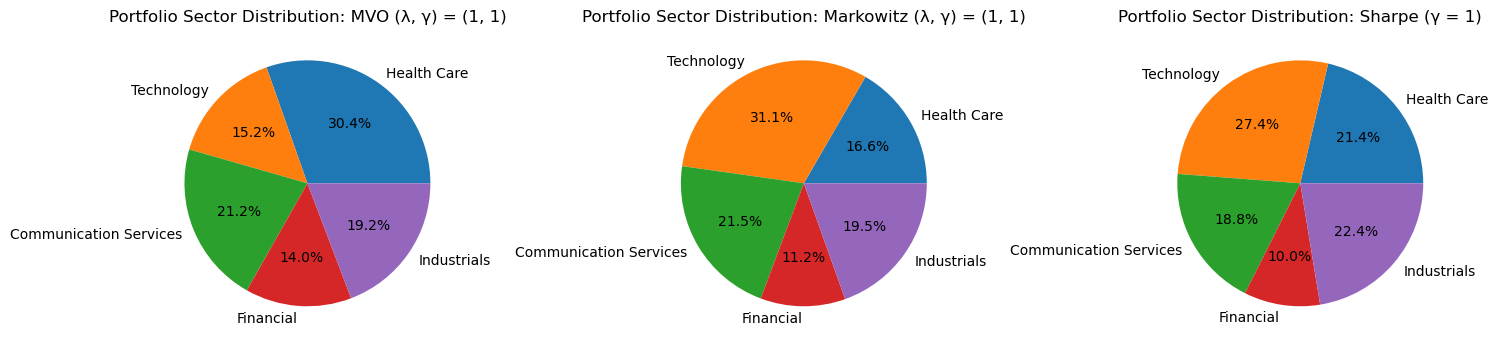

In [6]:
x = 1 # lambda input
y = 1 # Gamma input
# Call the functions once and store the results
mvo_result = MVO(x, y)
markowitz_result = Markowitz(x, y)
sharpe_result = Sharpe(y)

# Use the stored results to build the dictionary
portfolio_results = Dict(
    :MVO => (weights = mvo_result[1], ret = mvo_result[2], risk = mvo_result[3], sharperatio = mvo_result[4]),
    :Markowitz => (weights = markowitz_result[1], ret = markowitz_result[2], risk = markowitz_result[3], sharperatio = markowitz_result[4]),
    :Sharpe => (weights = sharpe_result[1], ret = sharpe_result[2], risk = sharpe_result[3], sharperatio1 = sharpe_result[4])
)


# --- Plotting Sector Weights for Each Model ---
model_order = [:MVO, :Markowitz, :Sharpe]

# Set up subplots: 1 row, number of models as columns
num_models = length(model_order)
fig, axes = subplots(1, num_models, figsize=(15, 6))  # Adjust figsize as needed

# Iterate through the models in the desired order
for (i, model_key) in enumerate(model_order)
    result = portfolio_results[model_key]
    
    # Calculate sector weights for the current model
    sector_weights = Dict()
    for (sector, indices) in sector_id
        total_weight = sum(result.weights[i] for i in indices)
        sector_weights[sector] = total_weight
    end

    # Plot pie chart on the corresponding subplot
    ax = axes[i]  # Select the subplot
    ax.pie(collect(values(sector_weights)), 
           labels=collect(keys(sector_weights)),
           autopct="%1.1f%%")
    
    if haskey(result, :sharperatio1)  # Sharpe model does not have λ
        title_text = "Portfolio Sector Distribution: $model_key (γ = $y)"
    else
        title_text = "Portfolio Sector Distribution: $model_key (λ, γ) = ($x, $y)"
    end
    ax.set_title(title_text)
    
end

# Adjust layout to prevent overlap and show the plots
tight_layout()
show()

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


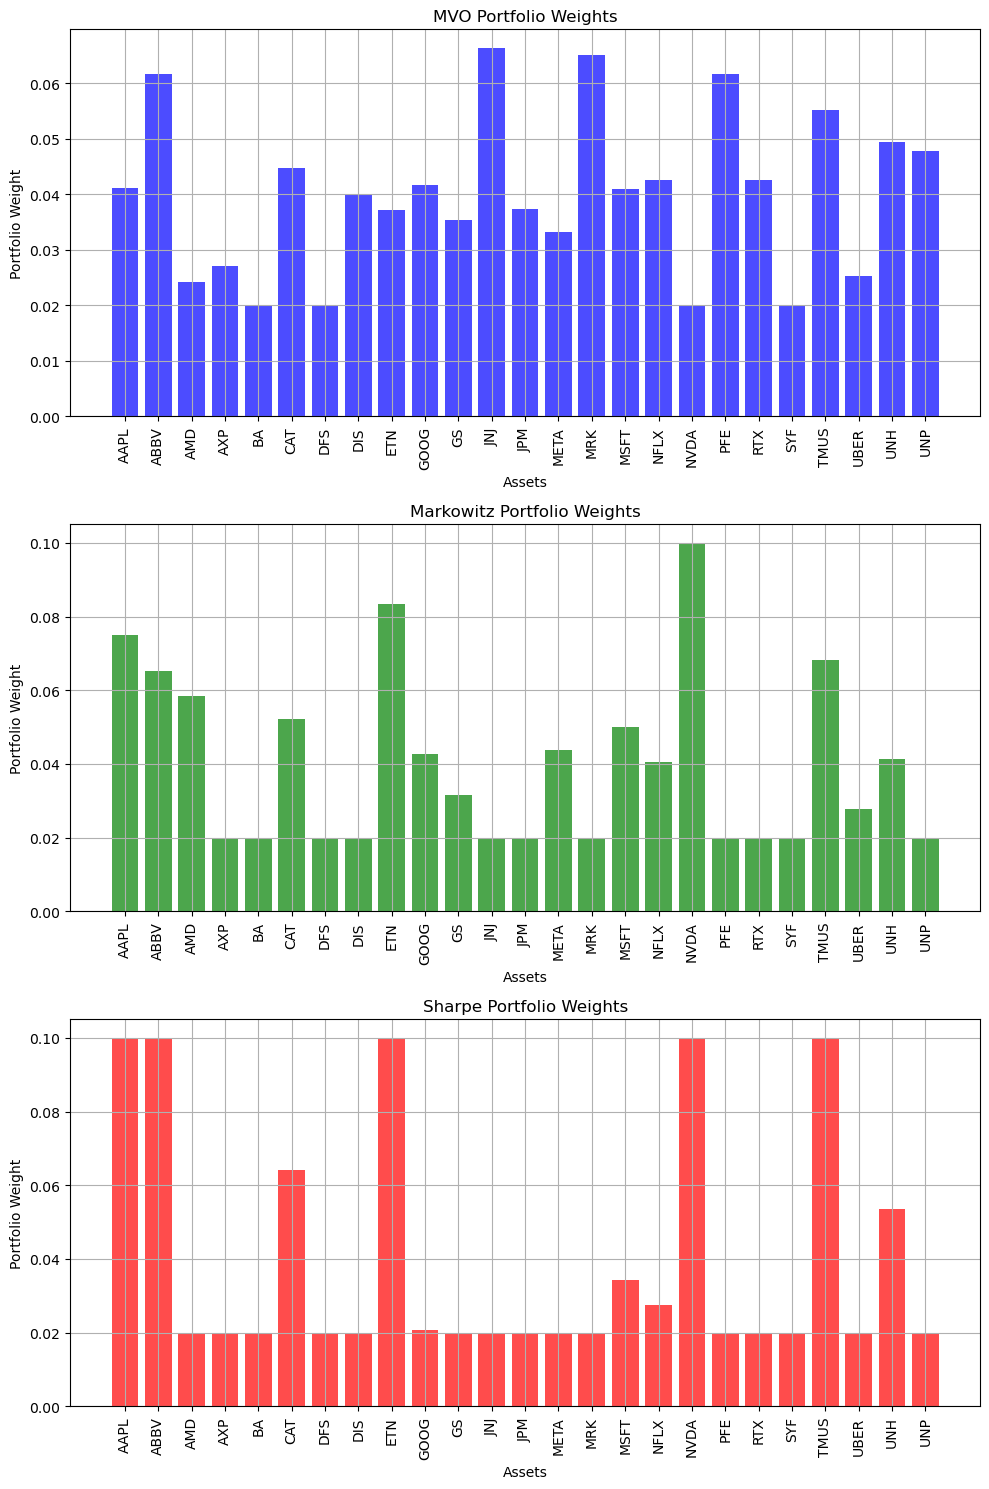

In [46]:
figure(figsize=(10, 15))  

portfolio_names = collect(keys(portfolio_results))
colors = ["blue", "green", "red"]  

portfolio_order = [:MVO, :Markowitz, :Sharpe]
portfolio_names = filter(x -> x in portfolio_order, portfolio_order)

for (i, portfolio_name) in enumerate(portfolio_names)
    subplot(length(portfolio_results), 1, i)  # Change to vertical layout
    portfolio_weights = portfolio_results[portfolio_name][:weights]
    bar(1:n_assets, portfolio_weights, color=colors[i], alpha=0.7)
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Assets")
    ylabel("Portfolio Weight")
    title("$portfolio_name Portfolio Weights")
    grid(true)
    tight_layout()
end

show()

## 4.2 Cumulative Weight Distribution Analysis

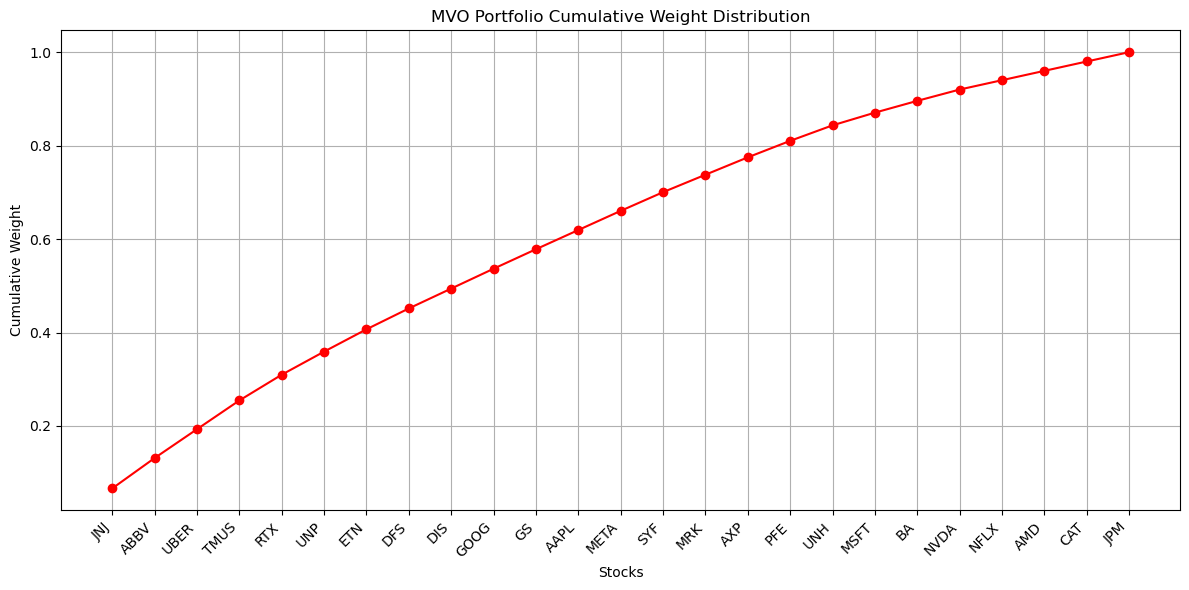

In [47]:
sorted_weights = sort(collect(zip(final_df.StockName, mvo_result[1])), by=x->x[2], rev=true)

# Plot cumulative weights
figure(figsize=(12, 6))
weights = [w[2] for w in sorted_weights]
cumsum_weights = cumsum(weights)
plot(1:length(weights), cumsum_weights, "ro-")  # Changed 'ro-' to "ro-"
xticks(1:length(weights), [w[1] for w in sorted_weights], rotation=45, ha="right")
xlabel("Stocks")
ylabel("Cumulative Weight")
title("MVO Portfolio Cumulative Weight Distribution")
grid(true)
tight_layout()
savefig("cumulative_weights_mvo.png")

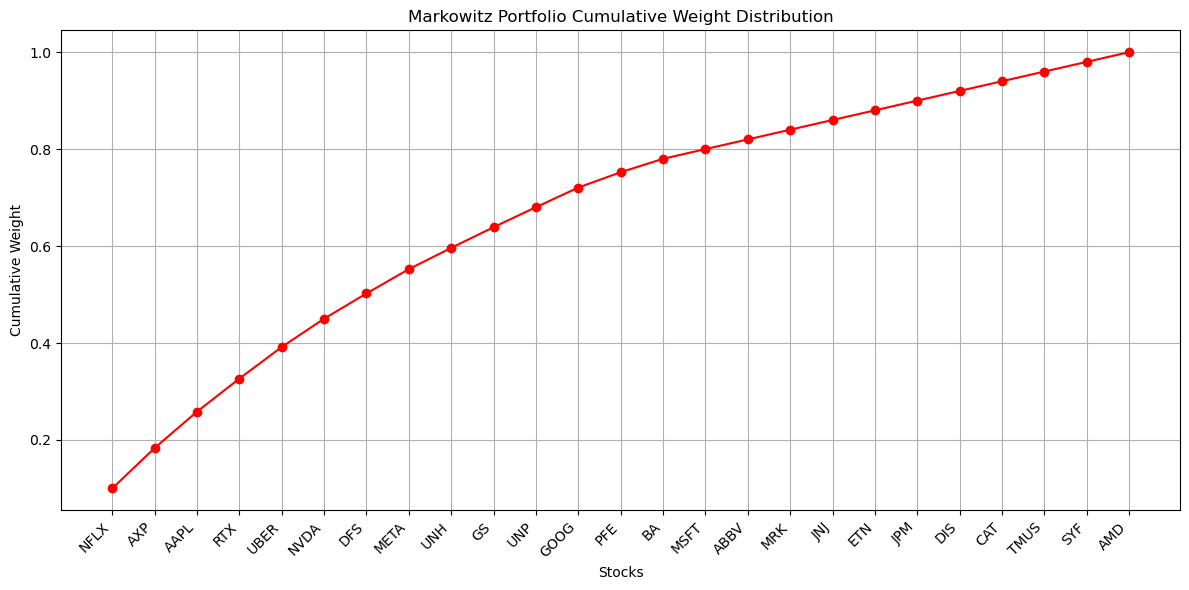

In [48]:
sorted_weights = sort(collect(zip(final_df.StockName, markowitz_result[1])), by=x->x[2], rev=true)

# Plot cumulative weights
figure(figsize=(12, 6))
weights = [w[2] for w in sorted_weights]
cumsum_weights = cumsum(weights)
plot(1:length(weights), cumsum_weights, "ro-")  # Changed 'ro-' to "ro-"
xticks(1:length(weights), [w[1] for w in sorted_weights], rotation=45, ha="right")
xlabel("Stocks")
ylabel("Cumulative Weight")
title("Markowitz Portfolio Cumulative Weight Distribution")
grid(true)
tight_layout()
savefig("cumulative_weights_markowitz.png")

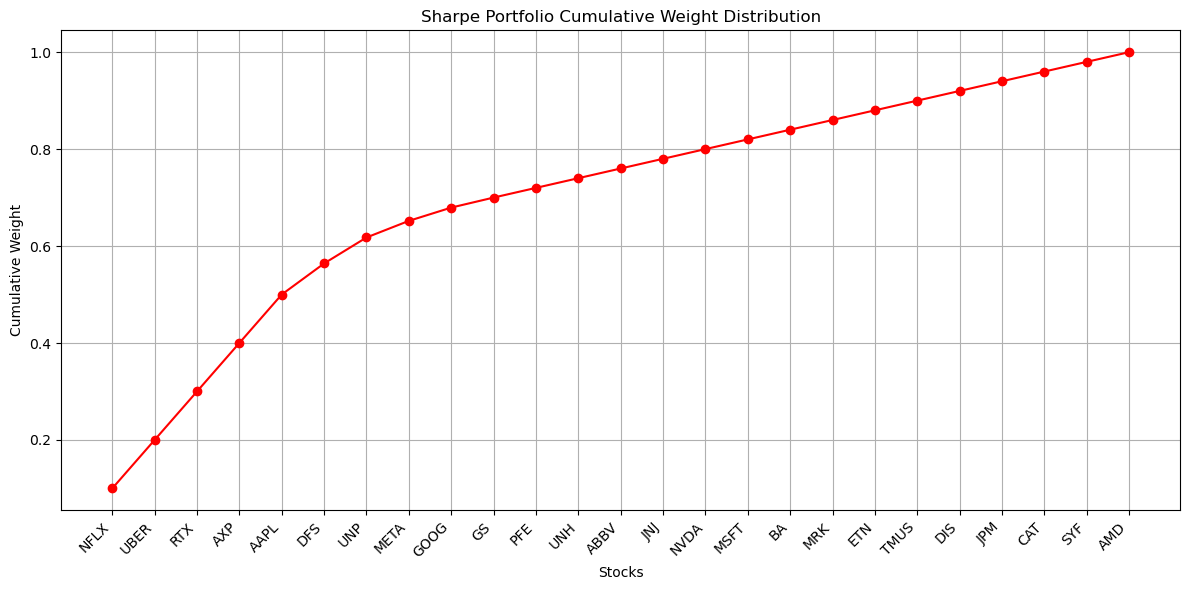

In [49]:
sorted_weights = sort(collect(zip(final_df.StockName, sharpe_result[1])), by=x->x[2], rev=true)

# Plot cumulative weights
figure(figsize=(12, 6))
weights = [w[2] for w in sorted_weights]
cumsum_weights = cumsum(weights)
plot(1:length(weights), cumsum_weights, "ro-")  # Changed 'ro-' to "ro-"
xticks(1:length(weights), [w[1] for w in sorted_weights], rotation=45, ha="right")
xlabel("Stocks")
ylabel("Cumulative Weight")
title("Sharpe Portfolio Cumulative Weight Distribution")
grid(true)
tight_layout()
savefig("cumulative_weights_sharpe.png")

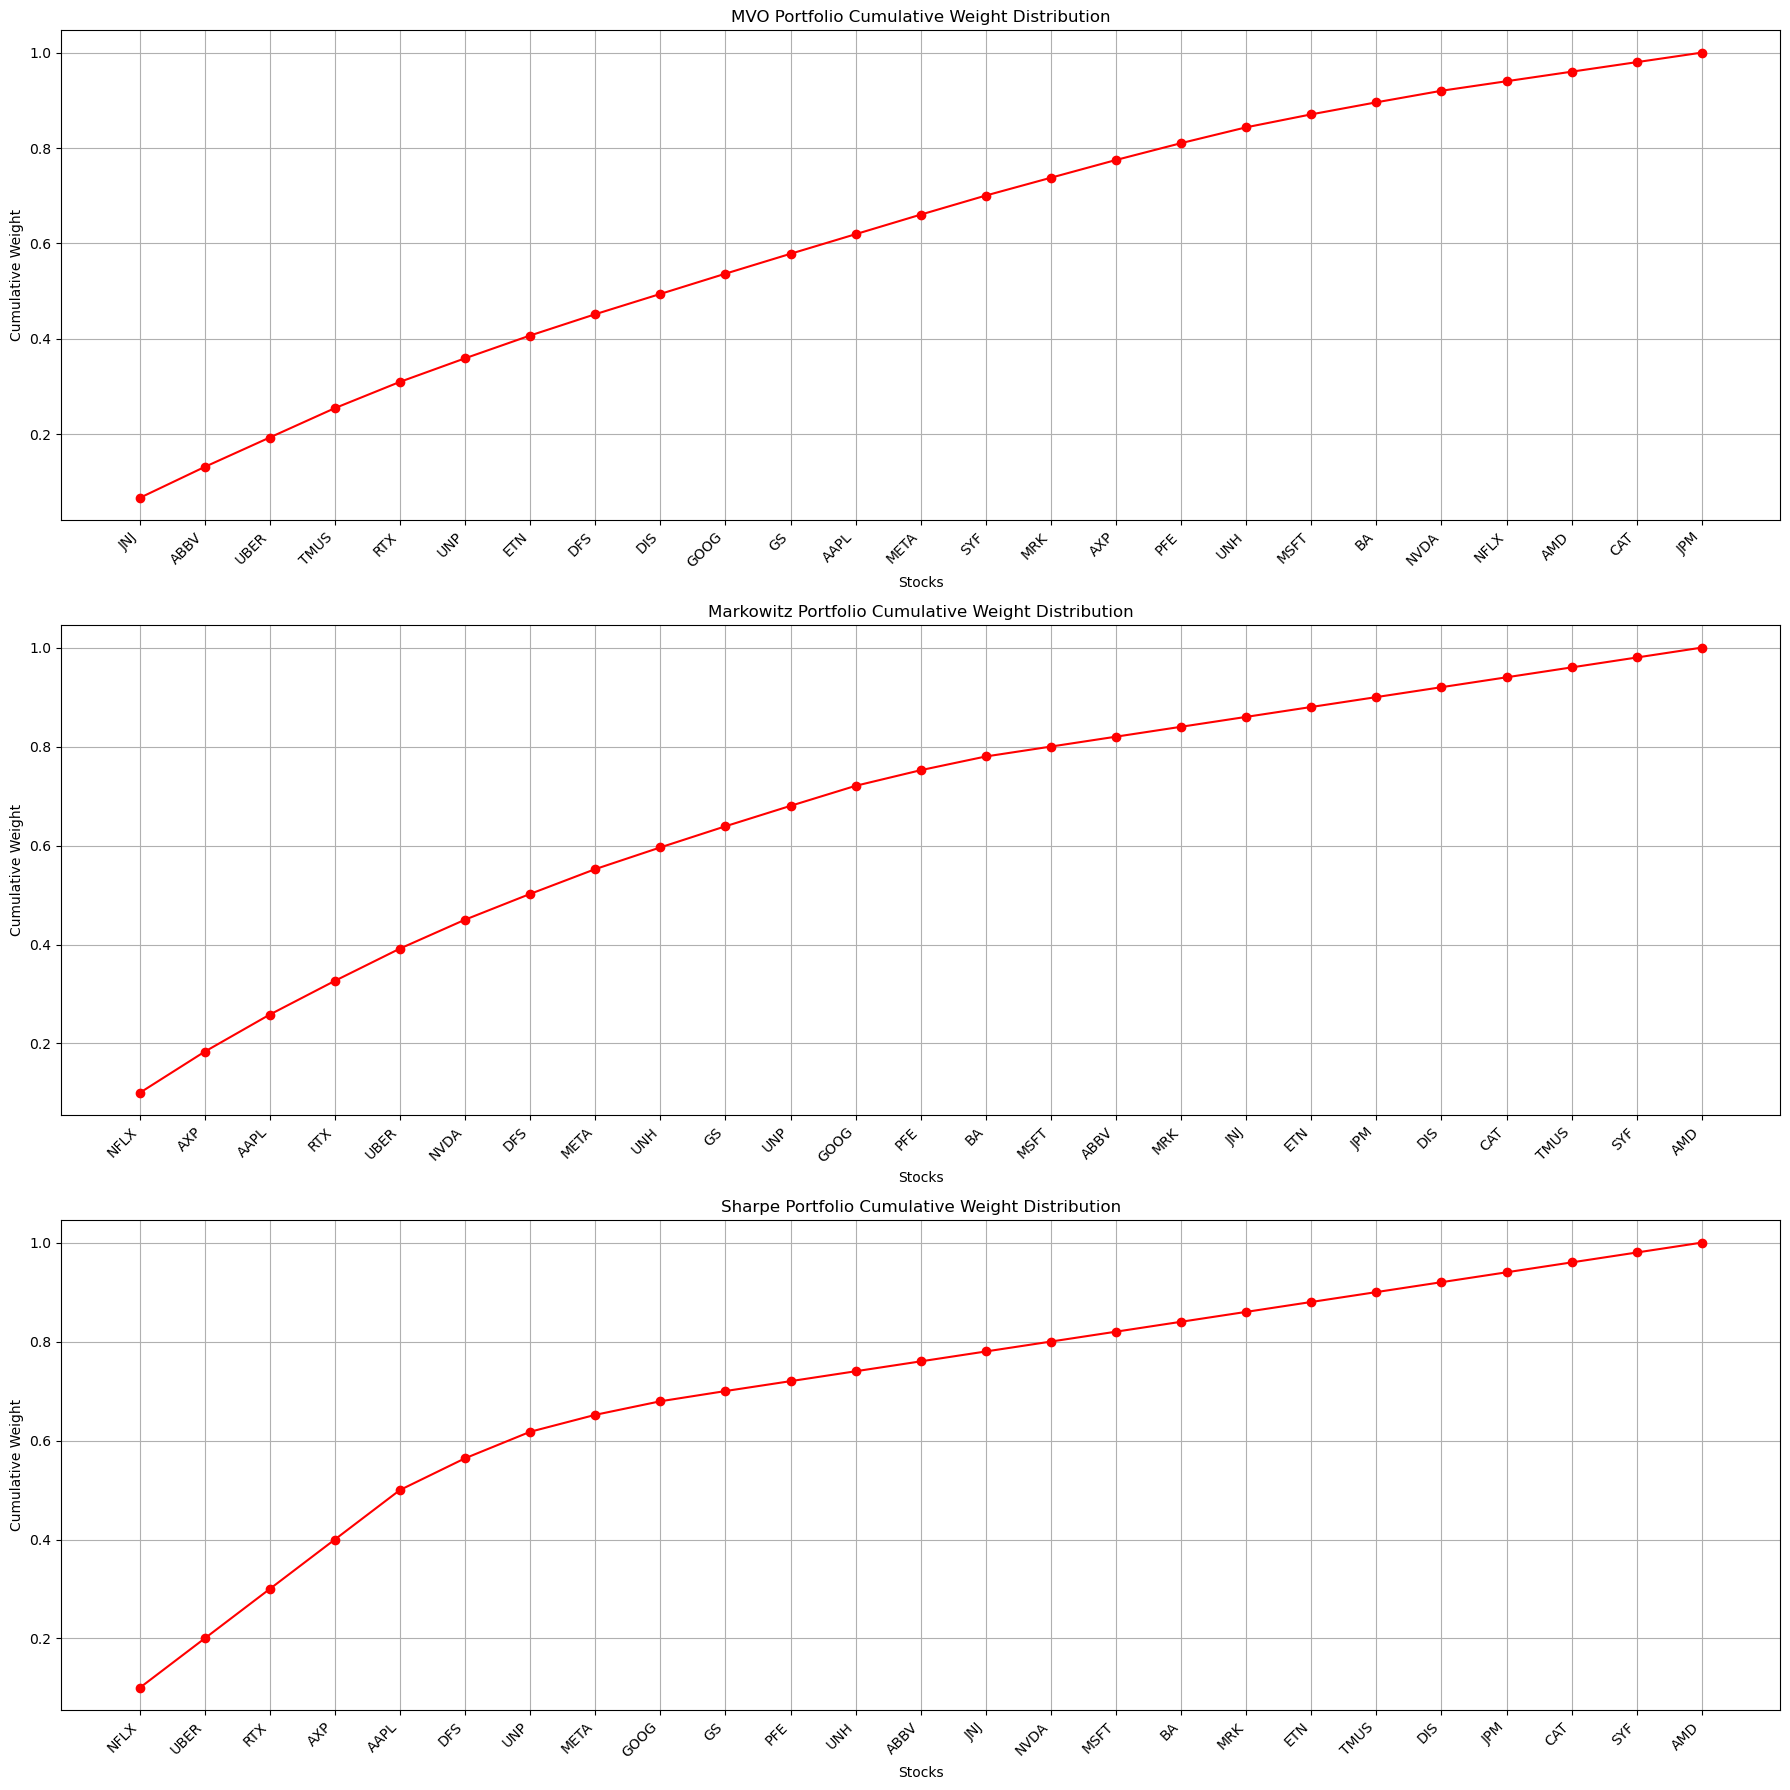

In [50]:
figure(figsize=(18, 18))  # Adjust figure size to accommodate three subplots

# Plot for MVO Portfolio Cumulative Weight Distribution
subplot(3, 1, 1)
sorted_weights = sort(collect(zip(final_df.StockName, mvo_result[1])), by=x->x[2], rev=true)
weights = [w[2] for w in sorted_weights]
cumsum_weights = cumsum(weights)
plot(1:length(weights), cumsum_weights, "ro-")
xticks(1:length(weights), [w[1] for w in sorted_weights], rotation=45, ha="right")
xlabel("Stocks")
ylabel("Cumulative Weight")
title("MVO Portfolio Cumulative Weight Distribution")
grid(true)
tight_layout()

# Plot for Markowitz Portfolio Cumulative Weight Distribution
subplot(3, 1, 2)
sorted_weights = sort(collect(zip(final_df.StockName, markowitz_result[1])), by=x->x[2], rev=true)
weights = [w[2] for w in sorted_weights]
cumsum_weights = cumsum(weights)
plot(1:length(weights), cumsum_weights, "ro-")
xticks(1:length(weights), [w[1] for w in sorted_weights], rotation=45, ha="right")
xlabel("Stocks")
ylabel("Cumulative Weight")
title("Markowitz Portfolio Cumulative Weight Distribution")
grid(true)
tight_layout()

# Plot for Sharpe Portfolio Cumulative Weight Distribution
subplot(3, 1, 3)
sorted_weights = sort(collect(zip(final_df.StockName, sharpe_result[1])), by=x->x[2], rev=true)
weights = [w[2] for w in sorted_weights]
cumsum_weights = cumsum(weights)
plot(1:length(weights), cumsum_weights, "ro-")
xticks(1:length(weights), [w[1] for w in sorted_weights], rotation=45, ha="right")
xlabel("Stocks")
ylabel("Cumulative Weight")
title("Sharpe Portfolio Cumulative Weight Distribution")
grid(true)
tight_layout()

savefig("cumulative_weights_combined.png")

## 4.3 Diversification Sensitivity Analysis

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


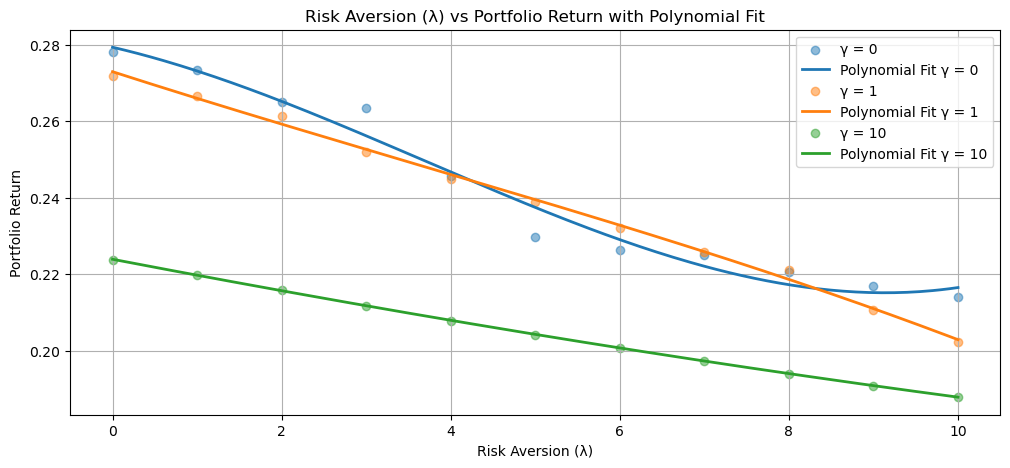

In [15]:
λ_values = 0:10
γ_values = [0, 1, 10]  

results = []

for γ in γ_values
    for λ in λ_values
        port = Markowitz(λ, γ)
        if !isnothing(port)
            push!(results, (λ, γ, port[2], port[3]))
        end
    end
end

# Data processing
figure(figsize=(12, 5))

for γ in γ_values
    # Filter results for the current γ
    γ_results = filter(r -> r[2] == γ, results)
    λ_vals = [r[1] for r in γ_results]
    ret_vals = [r[3] for r in γ_results]

    # Fit a polynomial to the data
    degree = 3  # Degree of the polynomial
    X = hcat([λ_vals.^k for k in degree:-1:0]...)  # Design matrix for the polynomial
    coeffs = X \ ret_vals  # Solve for polynomial coefficients

    # Polynomial function
    poly_fit = x -> sum(coeffs[i] * x^(degree - i + 1) for i in 1:length(coeffs))

    # Scatter plot for the data points
    scatter(λ_vals, ret_vals, label="γ = $γ", alpha=0.5)

    # Plot the fitted polynomial
    x_fit = range(minimum(λ_vals), stop=maximum(λ_vals), length=200)
    y_fit = [poly_fit(x) for x in x_fit]
    plot(x_fit, y_fit, label="Polynomial Fit γ = $γ", lw=2)
end

# Labels and title
xlabel("Risk Aversion (λ)")
ylabel("Portfolio Return")
title("Risk Aversion (λ) vs Portfolio Return with Polynomial Fit")
legend()
grid(true)
show()


## 4.4 Trade-off Analysis 

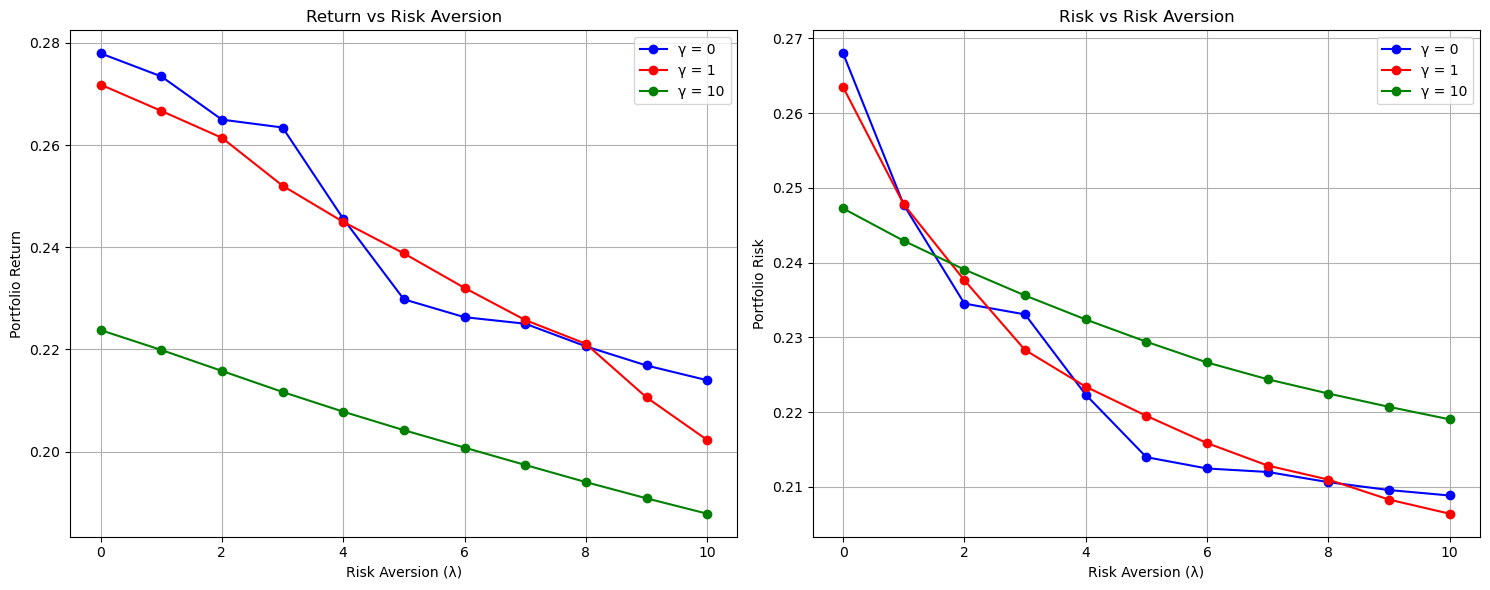

In [16]:
using JuMP, Ipopt, PyPlot, LinearAlgebra

figure(figsize=(15, 6))

colors = ["b", "r", "g", "m", "c"]  

# return plot
subplot(1, 2, 1)
for (i, γ) in enumerate(γ_values)
    γ_results = filter(r -> r[2] == γ, results)
    plot([r[1] for r in γ_results], 
         [r[3] for r in γ_results], 
         "o-", 
         color=colors[i],
         label="γ = $γ")
end
xlabel("Risk Aversion (λ)")
ylabel("Portfolio Return")
title("Return vs Risk Aversion")
legend()
grid(true)

# risk plot
subplot(1, 2, 2)
for (i, γ) in enumerate(γ_values)
    γ_results = filter(r -> r[2] == γ, results)
    plot([r[1] for r in γ_results], 
         [r[4] for r in γ_results], 
         "o-", 
         color=colors[i],
         label="γ = $γ")
end
xlabel("Risk Aversion (λ)")
ylabel("Portfolio Risk")
title("Risk vs Risk Aversion")
legend()
grid(true)

tight_layout()
savefig("risk_return_tradeoff_gamma_lambda.png")


##  Sensitivity Analysis

The sensitivity analysis reveals complex interactions between the minimum return requirement (R_min) and risk aversion coefficient (λ). When R_min is low (0.001), the portfolio exhibits high sensitivity to changes in λ, with returns decreasing from 337.68% to 24.15% and risk reducing from 44.15% to 0.06% as λ increases from 1 to 100. This demonstrates the dominant effect of risk aversion when return constraints are not binding.

However, as R_min increases, we observe a distinctive "threshold effect" where the minimum return constraint becomes binding, limiting the impact of risk aversion. For R_min = 2.0, the portfolio maintains a constant return of 200% and risk of 14.7% when λ ≥ 10, while for R_min = 3.0, the portfolio stabilizes at a 300% return and 34.52% risk when λ ≥ 5. This pattern indicates that higher minimum return requirements effectively constrain the risk-minimization objective, creating a floor for both return and risk levels regardless of further increases in risk aversion.

These findings suggest that the effectiveness of risk control through λ adjustment is significantly influenced by the minimum return requirement, with higher R_min values reducing the available risk-return trade-off space. This interaction provides crucial insights for portfolio managers in setting appropriate risk-return targets and understanding their feasible investment options.


# 5. Conclusion

# 6. References

- Team, T. I. (2023, August 29). Modern portfolio theory: What MPT is and how investors use it. Investopedia. https://www.investopedia.com/terms/m/modernportfoliotheory.asp?utm_source=chatgpt.com 